# Design Space Exploration

In this demonstration we show how we can leverage the `OptProblem` class from the `standard_evaluator` library to perform optimization studies that can be version controlled. 

![Design Space Exploration (running multiple optimizations) process](design_space_exploration.drawio.png)

The idea is that we will want to run multiple optimization problems that are driven by JSOn files that we can version control. In a future step we will also manage the assembly information itself in a JSON file that can be version controlled, but for this demonstration we went down an easier path.

We first load all required libraries and methods.

In [1]:
import typing
import openmdao.api as om
import openmdao.core.system as oms
import pandas as pd

from standard_evaluator import get_interface, show_structure, create_problem, get_state, set_state, load_state, save_state
from standard_evaluator import load_assembly, save_assembly, convert_om_var, get_opt_problem, set_opt_problem
from standard_evaluator import Variable, FloatVariable, IntVariable, ArrayVariable, OptProblem

## Creating the OpenMDAO assembly

In this example we use the Sellar Problem from the [OpenMDAO documentation](https://openmdao.org/newdocs/versions/latest/basic_user_guide/multidisciplinary_optimization/sellar_opt.html). 

We first setup the assembly, set the optimization variables, constraints, and the objective. We can then run the optimization.

In [2]:
import numpy as np
import openmdao.api as om

from openmdao.test_suite.components.sellar import SellarDis1, SellarDis2


class SellarMDA(om.Group):
    """
    Group containing the Sellar MDA.
    """

    def setup(self):
        cycle = self.add_subsystem('cycle', om.Group(), promotes=['*'])
        cycle.add_subsystem('d1', SellarDis1(), promotes_inputs=['x', 'z', 'y2'],
                            promotes_outputs=['y1'])
        cycle.add_subsystem('d2', SellarDis2(), promotes_inputs=['z', 'y1'],
                            promotes_outputs=['y2'])

        cycle.set_input_defaults('x', 1.0)
        cycle.set_input_defaults('z', np.array([5.0, 2.0]))

        # Nonlinear Block Gauss Seidel is a gradient free solver
        cycle.nonlinear_solver = om.NonlinearBlockGS()

        self.add_subsystem('obj_cmp', om.ExecComp('obj = x**2 + z[1] + y1 + exp(-y2)',
                                                  z=np.array([0.0, 0.0]), x=0.0),
                           promotes=['x', 'z', 'y1', 'y2', 'obj'])

        self.add_subsystem('con_cmp1', om.ExecComp('con1 = 3.16 - y1'), promotes=['con1', 'y1'])
        self.add_subsystem('con_cmp2', om.ExecComp('con2 = y2 - 24.0'), promotes=['con2', 'y2'])

class SellarMDA(om.Group):
    """
    Group containing the Sellar MDA.
    """

    def setup(self):
        cycle = self.add_subsystem('cycle', om.Group(), promotes=['*'])
        cycle.add_subsystem('d1', SellarDis1(), promotes_inputs=['x', 'z', 'y2'],
                            promotes_outputs=['y1'])
        cycle.add_subsystem('d2', SellarDis2(), promotes_inputs=['z', 'y1'],
                            promotes_outputs=['y2'])

        cycle.set_input_defaults('x', 1.0)
        cycle.set_input_defaults('z', np.array([5.0, 2.0]))

        # Nonlinear Block Gauss Seidel is a gradient free solver
        cycle.nonlinear_solver = om.NonlinearBlockGS()

        self.add_subsystem('obj_cmp', om.ExecComp('obj = x**2 + z[1] + y1 + exp(-y2)',
                                                  z=np.array([0.0, 0.0]), x=0.0),
                           promotes=['x', 'z', 'y1', 'y2', 'obj'])

        self.add_subsystem('con_cmp1', om.ExecComp('con1 = 3.16 - y1'), promotes=['con1', 'y1'])
        self.add_subsystem('con_cmp2', om.ExecComp('con2 = y2 - 24.0'), promotes=['con2', 'y2'])

import openmdao.api as om
from openmdao.test_suite.components.sellar_feature import SellarMDA

prob = om.Problem()
prob.model = SellarMDA()

prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'
# prob.driver.options['maxiter'] = 100
prob.driver.options['tol'] = 1e-8

prob.model.add_design_var('x', lower=0, upper=10)
prob.model.add_design_var('z', lower=0, upper=10)
prob.model.add_objective('obj')
prob.model.add_constraint('con1', upper=0)
prob.model.add_constraint('con2', upper=0)

# Ask OpenMDAO to finite-difference across the model to compute the gradients for the optimizer
prob.model.approx_totals()

prob.setup()
prob.set_solver_print(level=0)

prob.run_driver()

print('minimum found at')
print(prob.get_val('x')[0])
print(prob.get_val('z'))

print('minumum objective')
print(prob.get_val('obj')[0])

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.183393951729169
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization Complete
-----------------------------------
minimum found at
0.0
[1.97763888e+00 8.83056605e-15]
minumum objective
3.183393951729169


In the next step we get the description of the optimization problem and store that in an instance of the neutral `OptProblem`. We also capture the structure of the assembly in the neutral format.

We show the content of the `original_opt` variable,

In [3]:
original_opt = get_opt_problem(prob)
info = get_interface(prob.model)
original_opt

OptProblem(name='opt_problem', class_type='OptProblem', variables=[FloatVariable(name='x', default=None, bounds=(0.0, 10.0), shift=0.0, scale=1.0, units=None, description='', options={'parallel_deriv_color': None}, class_type='float'), ArrayVariable(name='z', default=None, bounds=(array([0., 0.]), array([10., 10.])), shift=array([0., 0.]), scale=array([1., 1.]), units=None, description='', options={'parallel_deriv_color': None}, class_type='floatarray', shape=(2,))], responses=[FloatVariable(name='con1', default=None, bounds=(-1e+30, 0.0), shift=0.0, scale=1.0, units=None, description='', options={'parallel_deriv_color': None}, class_type='float'), FloatVariable(name='con2', default=None, bounds=(-1e+30, 0.0), shift=0.0, scale=1.0, units=None, description='', options={'parallel_deriv_color': None}, class_type='float'), FloatVariable(name='obj', default=None, bounds=(-inf, inf), shift=0.0, scale=1.0, units=None, description='', options={'parallel_deriv_color': None}, class_type='float')

## Setting up a series of optimization studies

In the next step we take the original optimization problem and create a series of optimization problems where we change the upper bound of the first nonlinear constraint. This is a typical scenario in industry, we are trying to explore the design space and often the constraints are not fully defined.

We store all of the optimization problems in JSON files. This will allow us to fully describe the studies we are doing, and they can be version controlled. 

In [8]:
import json

bound_values = [-3.5, -2.5, -1.5, -.5, -.4, -.3, -.2, -.1, 0.0, .1, .2]
indx = 0
for upper in bound_values:
    new_opt = original_opt.model_copy()
    new_opt.responses[0].bounds = (-np.inf, upper)
    optproblem_name = f'optproblem{indx:02}.json'
    indx += 1
    # Convert and write JSON object to file
    with open(optproblem_name, "w") as outfile:
        json.dump(new_opt.model_dump(exclude_unset=True), outfile, indent=2, skipkeys=True)


## Running a series of optimization problems

In the next step we actually run the different optimization problems. To do this we first create a pattern for all the optimization files, and get the names of all of them.

Then we run a loop through all the file names, first loading the optimization problem formulation into a dictionary, convert it into `OptProblem`'s, create a new instance of the Sellar problem, set the optimization problem, the optimzition parameters, and run the optimization. We store the results from the optimization in a Pandas DataFrame together with the name of the file that defined the specific optimization problem.

After running all the optimizations we combine the results into a single DataFrame, and show the summary.

In [9]:
solutions = []
import glob

# Specify the pattern for the JSON files
pattern = 'optproblem*.json'

# Use glob to find all files matching the pattern
json_files = glob.glob(pattern)

# Loop through the list of files and load each JSON file
data_list = []
for file in json_files:
    with open(file, 'r') as f:
        data = json.load(f)  # Load the JSON data
    new_opt = OptProblem.model_validate(data)
    new_prob = om.Problem()
    new_prob.model = SellarMDA()

    # Setting the optimization problem
    set_opt_problem(new_prob, new_opt)

    # Setting the optimizer options.
    new_prob.driver = om.ScipyOptimizeDriver()
    new_prob.driver.options['optimizer'] = 'SLSQP'
    # prob.driver.options['maxiter'] = 100
    new_prob.driver.options['tol'] = 1e-8

    # Ask OpenMDAO to finite-difference across the model to compute the gradients for the optimizer
    new_prob.model.approx_totals()

    new_prob.set_solver_print(level=0)

    # Run the optimization
    new_prob.run_driver()

    # Get the state of the assembly, which will be the optimization solution
    state = get_state(new_prob, info)
    # We will store the solution in a dictionary, including the name of the file.
    state = {key: value.flatten()[0] if len(value) == 1 else value for key, value in state.items()}
    state['name'] = file

    # Convert the dictionary to a Pandas Series, and store as a DataFrame
    solutions.append(pd.Series(state).to_frame().T)

# Combine all the solutions into a single DataFrame
df = pd.concat(solutions)
# Show the result DataFrame
df


Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.664694351674094
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 5
Optimization Complete
-----------------------------------
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.667025907351937
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization Complete
-----------------------------------
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.670917299584386
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization Complete
-----------------------------------
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.677841549628989
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Op

,y1,y2,z,x,con1,con2,obj,name
0,6.66,5.361395,"[2.7806975800167444, 3.051394295571152e-12]",0.0,-3.5,-18.638605,6.664694,optproblem00.json
0,5.66,4.958151,"[2.5790754506581415, 6.221918747285027e-13]",0.0,-2.5,-19.041849,5.667026,optproblem01.json
0,4.66,4.517407,"[2.358703314489707, 1.2497789641957312e-13]",0.0,-1.5,-19.482593,4.670917,optproblem02.json
0,3.66,4.026225,"[2.1131126469752384, 0.0]",0.0,-0.5,-19.973775,3.677842,optproblem03.json
0,3.56,3.973592,"[2.086796226417705, 0.0]",0.0,-0.4,-20.026408,3.578806,optproblem04.json
0,3.46,3.920215,"[2.060107523783193, 0.0]",0.0,-0.3,-20.079785,3.479837,optproblem05.json
0,3.36,3.866061,"[2.0330302779941305, 6.990458292776596e-15]",0.0,-0.2,-20.133939,3.380941,optproblem06.json
0,3.26,3.811094,"[2.0055470085439713, 5.500933528914423e-15]",0.0,-0.1,-20.188906,3.282124,optproblem07.json
0,3.16,3.755278,"[1.977638883487764, 8.830566052859473e-15]",0.0,-0.0,-20.244722,3.183394,optproblem08.json
0,3.06,3.698571,"[1.9492855684910377, 0.0]",0.0,0.1,-20.301429,3.084759,optproblem09.json


Since in this example we only varied one constraint we can create a plot showing the impact of the change of the constraint on the value of the objective function, which is what we show next to finish this demonstration.

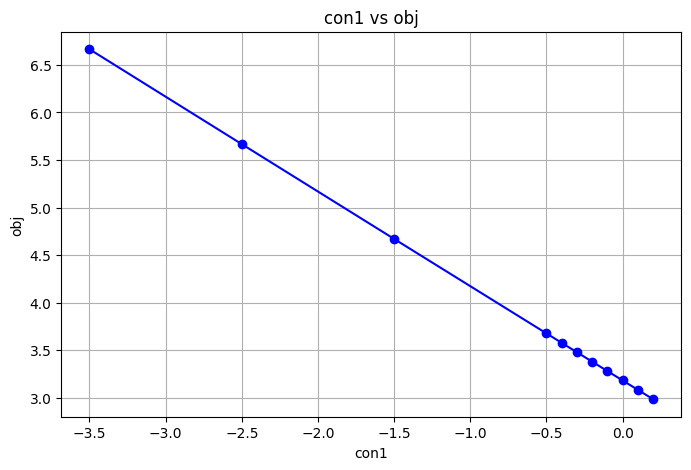

In [10]:
import matplotlib.pyplot as plt
# Ensure that plots are displayed inline in Jupyter Notebook
%matplotlib inline

# Plotting con1 vs obj
plt.figure(figsize=(8, 5))  # Optional: Set the figure size
plt.plot(df['con1'], df['obj'], marker='o', linestyle='-', color='b')  # Line plot with markers
plt.title('con1 vs obj')  # Title of the plot
plt.xlabel('con1')  # Label for x-axis
plt.ylabel('obj')  # Label for y-axis
plt.grid()  # Optional: Add a grid
plt.show()  # Display the plot